# Analysis

Let's look at one particular example of the CORD dataset.

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


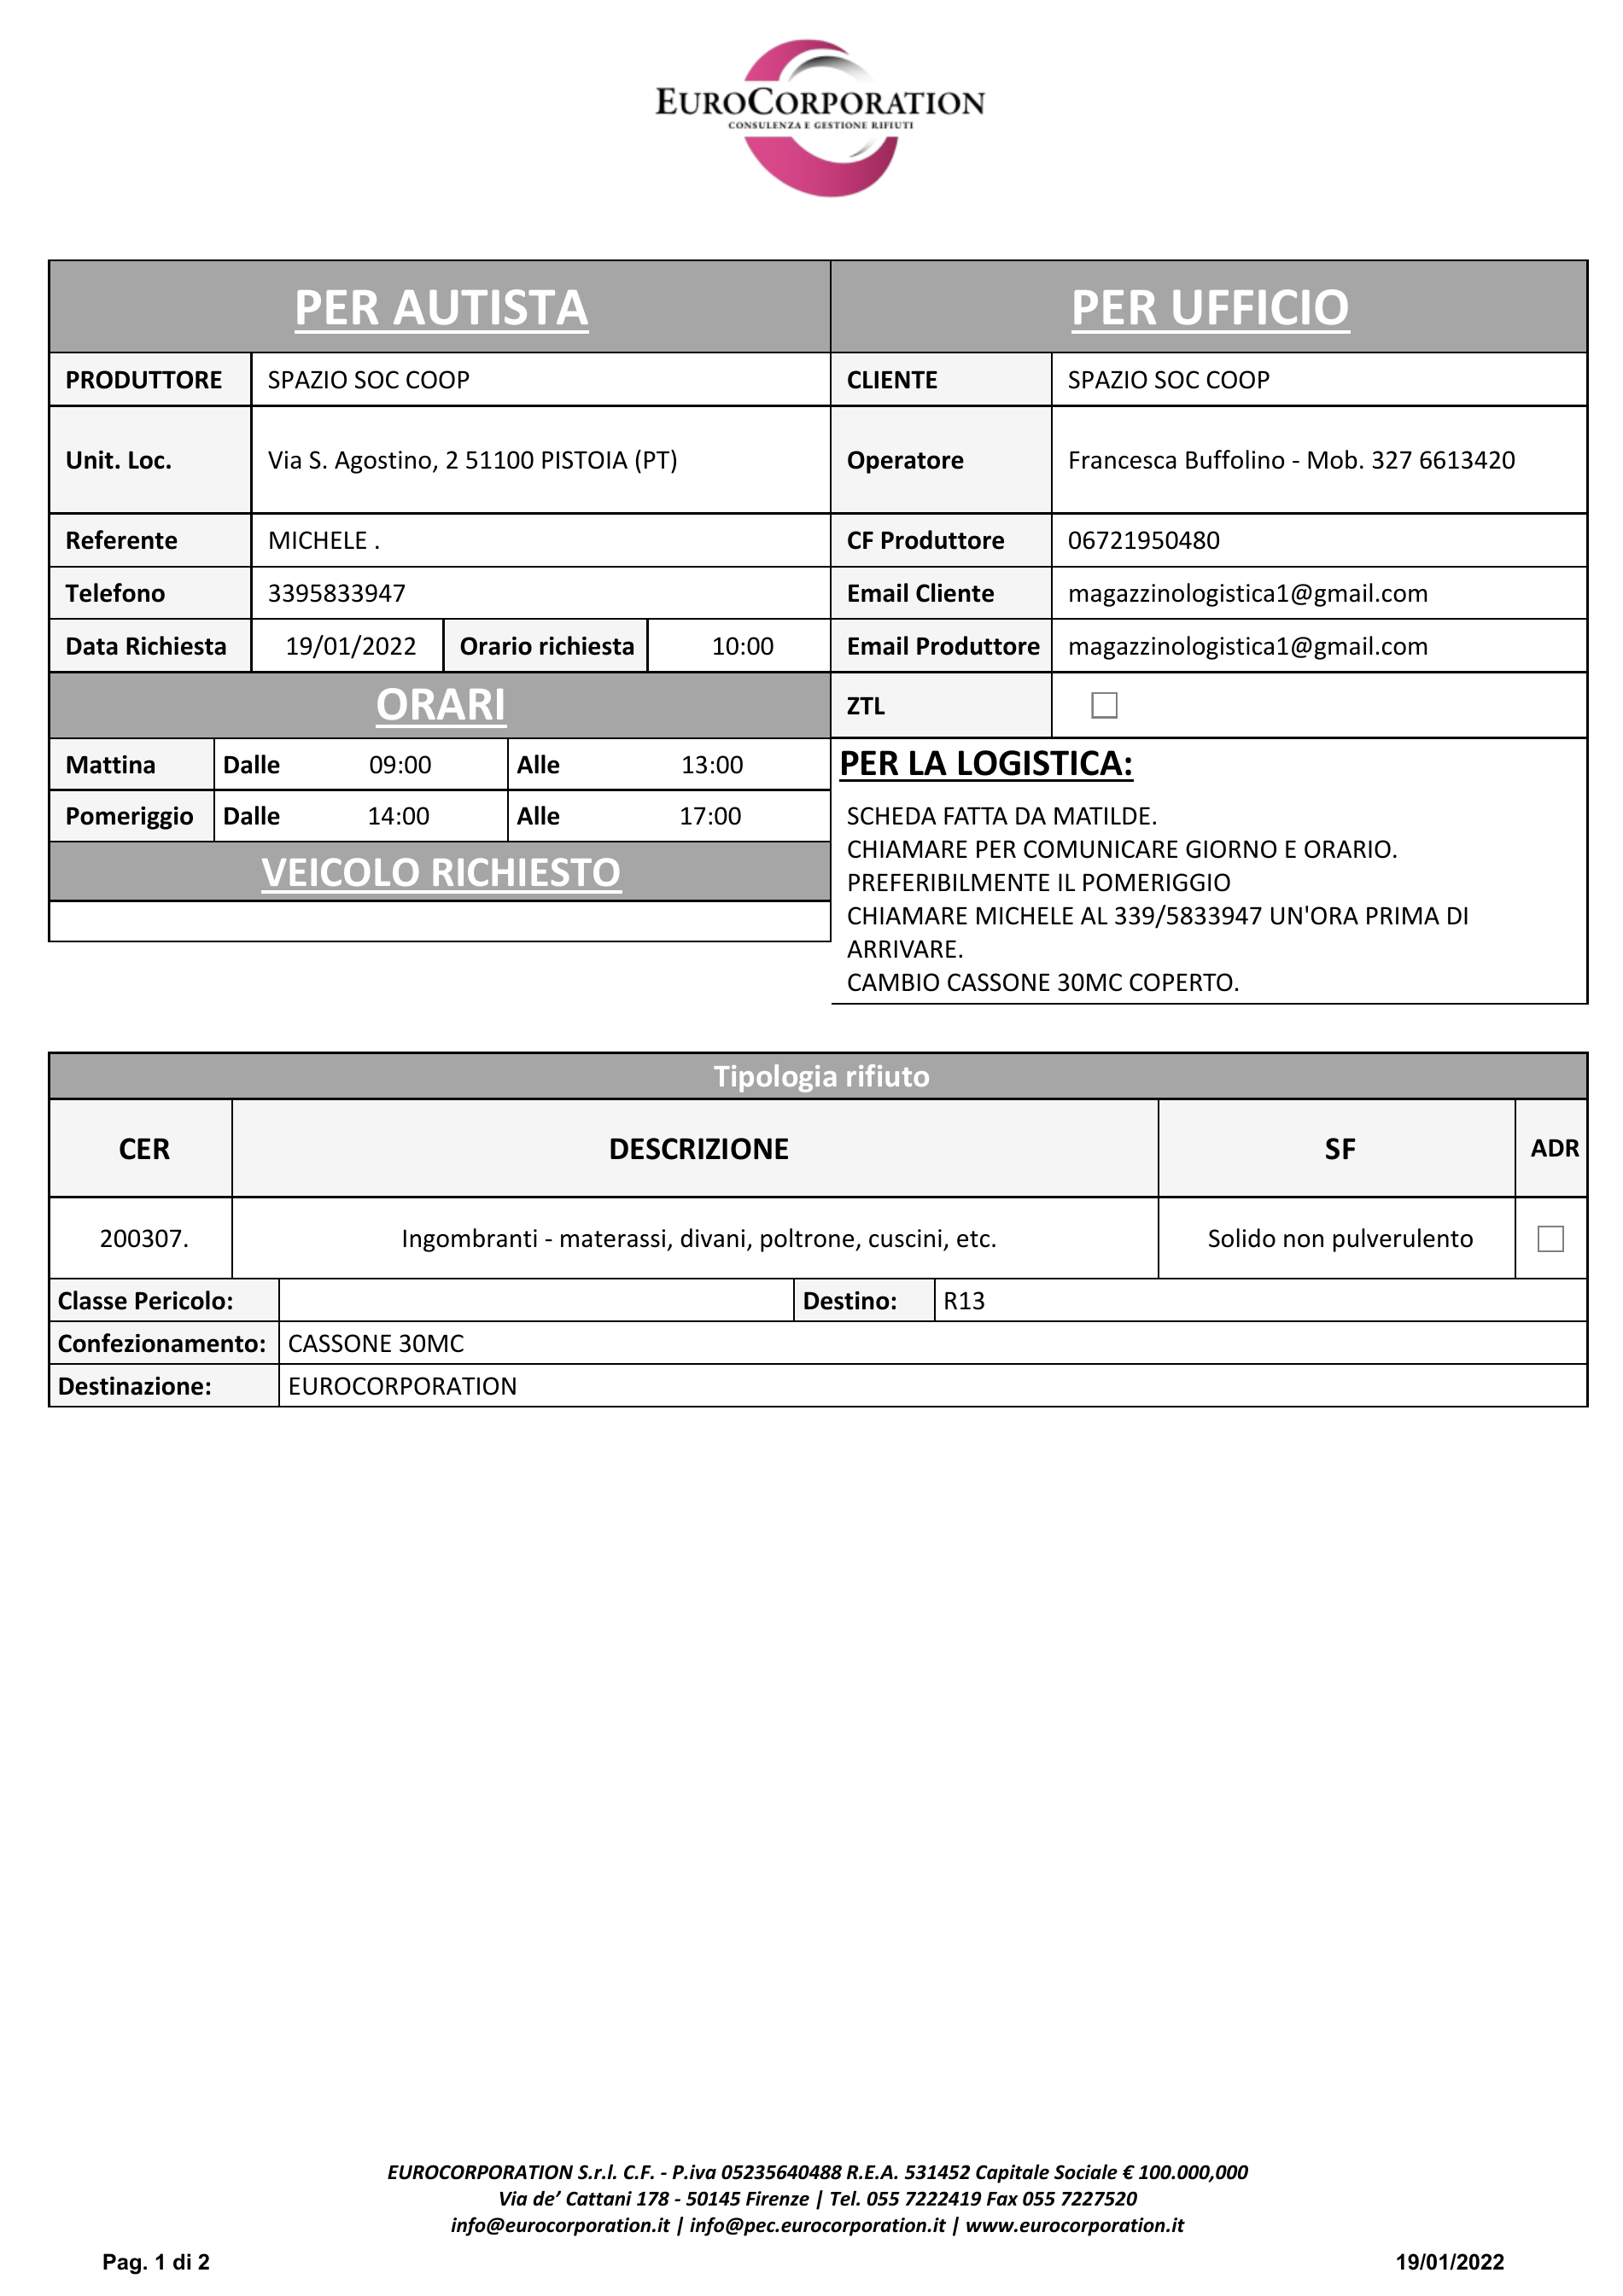

In [23]:
from PIL import Image

image = Image.open('/content/1.png')
image

Let's read in the corresponding OCR annotations.

In [24]:
import json

with open('/content/1.json') as json_file:
    data = json.load(json_file)

In [25]:
data.keys()

dict_keys(['dontcare', 'valid_line', 'meta', 'roi', 'repeating_symbol'])

In [26]:
data['meta']

{'image_size': {'height': 2690, 'width': 1901}, 'split': 'train'}

In [27]:
# data['roi']

In [28]:
# data['repeating_symbol']

This particular example has 93 OCR annotations:

In [29]:
len(data['valid_line'])

4

Let's look at the first one:

In [30]:
data['valid_line'][0]

{'category': 'produttore',
 'words': [{'quad': {'x1': 550,
    'x2': 425,
    'x3': 311,
    'x4': 311,
    'y1': 425,
    'y2': 550,
    'y3': 463,
    'y4': 463},
   'text': 'SPAZIO SOC COOP'}]}

Let's annotate the image with the corresponding bounding boxes:

In [31]:
import random

labels = ['produttore','UnitLoc','Referente','telefono']

get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
colors = get_colors(len(labels))
print(colors)

['#80c964', '#7bd0ee', '#f41c2a', '#f32971']


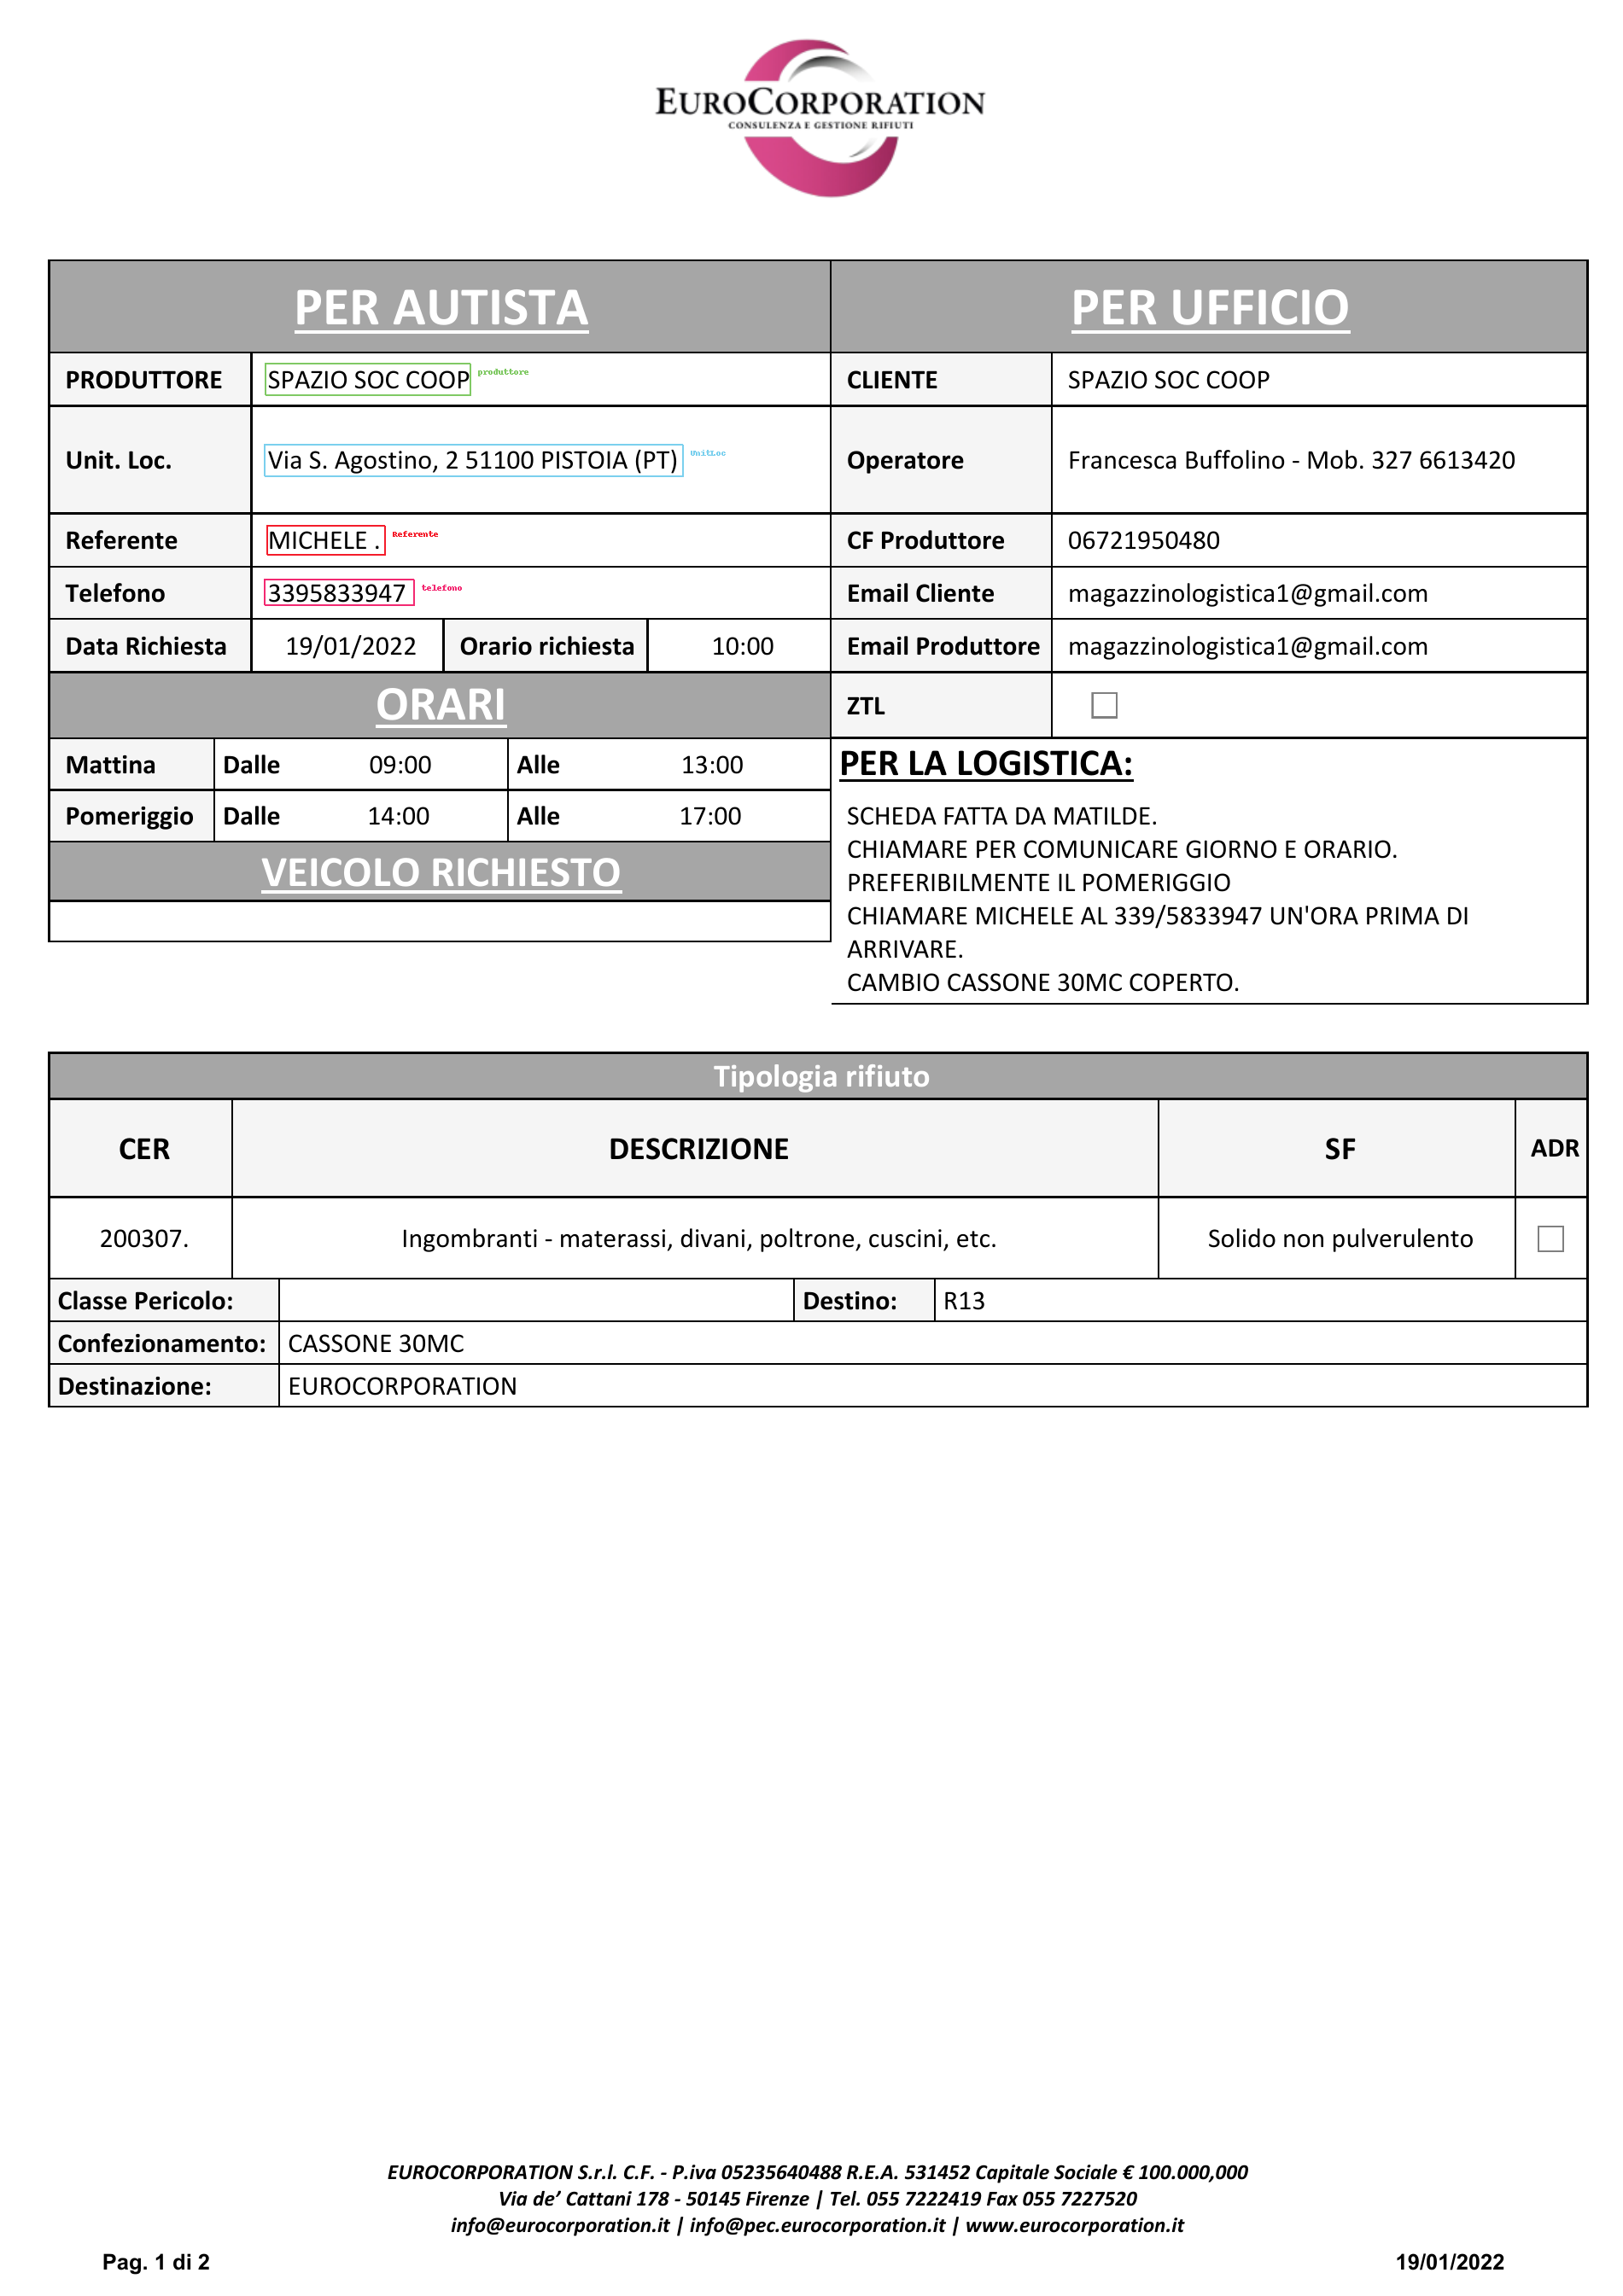

In [32]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image, "RGBA")

font = ImageFont.load_default()

label2color = {label: colors[idx] for idx, label in enumerate(labels)}

for annotation in data['valid_line']:
  label = annotation['category']
  words = annotation['words']
  for word in words:
    coordinates = word['quad']
    x1, y1 = coordinates['x1'], coordinates['y1']
    x3, y3 = coordinates['x3'], coordinates['y3']
    box = [x1, y1, x3, y3]
    draw.rectangle(box, outline=label2color[label], width=2)
    draw.text((box[0]+10, box[1]+5), label, fill=label2color[label], font=font)

image

# Generating the dataset

In [63]:
from tqdm.notebook import tqdm
import os

def normalize_bbox(bbox, width, height):
     return [
         int(1000 * (bbox[0] / width)),
         int(1000 * (bbox[1] / height)),
         int(1000 * (bbox[2] / width)),
         int(1000 * (bbox[3] / height)),
     ]

def generate_annotations(path: str):
  annotation_files = []
  for js in tqdm(os.listdir(path)):
    with open(path + js) as f:
        annotation_files.append(json.load(f))
  
  words = []
  boxes = []
  labels = []
  for js in tqdm(annotation_files):
      words_example = []
      boxes_example = []
      labels_example = []

      width, height = js['meta']['image_size']['width'], js['meta']['image_size']['height']
      print(" width, height: ", width, height)
      # loop over OCR annotations
      for elem in js['valid_line']:
          for word in elem['words']:
              # get word
              txt = word['text']
              print("TEXT: ", txt)

              # get bounding box
              # important: each bounding box should be in (upper left, lower right) format
              # it took me some time to understand the upper left is (x1, y3)
              # and the lower right is (x3, y1)
              x1 = word['quad']['x1']
              y1 = word['quad']['y1']
              x3 = word['quad']['x3']
              y3 = word['quad']['y3']
              
              box = [x1, y1, x3, y3]
              box = normalize_bbox(box, width=width, height=height)
              print("BOX: ", box)

              # ADDED
              # # skip empty word
              # if len(txt) < 1: 
              #   continue
              # if min(box) < 0 or max(box) > 1000: # another bug in which a box had -4
              #   continue
              # if ((box[3] - box[1]) < 0) or ((box[2] - box[0]) < 0): # another bug in which a box difference was -12
              #   continue
              # ADDED
              words.append(txt)
              print('words',words)
              boxes_example.append(box) 
              print('boxes_example',boxes_example)
              labels_example.append(elem['category'])
              print('LABLES: ', labels_example)
              print(words)

      boxes.append(boxes_example)
      labels.append(labels_example)

  return [words], boxes, labels

  train_path = '/content/data3/'
# val_path = '/content/drive/MyDrive/LayoutLMv2/Tutorial notebooks/CORD/CORD/dev/json/'
# test_path = '/content/drive/MyDrive/LayoutLMv2/Tutorial notebooks/CORD/CORD/test/json/'

words_train, boxes_train, labels_train = generate_annotations(train_path)
print("words",words_train)
print("boxes_train",boxes_train)
print("labels_train",labels_train)
# words_val, boxes_val, labels_val = generate_annotations(val_path)
# words_test, boxes_test, labels_test = generate_annotations(test_path)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 width, height:  1901 2690
TEXT:  SPAZIO SOC COOP
BOX:  [289, 157, 163, 172]
words ['SPAZIO SOC COOP']
boxes_example [[289, 157, 163, 172]]
LABLES:  ['produttore']
['SPAZIO SOC COOP']
TEXT:  Via S. Agostino ,2 51100 PISTOIA (PT)
BOX:  [420, 193, 163, 207]
words ['SPAZIO SOC COOP', 'Via S. Agostino ,2 51100 PISTOIA (PT)']
boxes_example [[289, 157, 163, 172], [420, 193, 163, 207]]
LABLES:  ['produttore', 'UnitLoc']
['SPAZIO SOC COOP', 'Via S. Agostino ,2 51100 PISTOIA (PT)']
TEXT:  MICHELE
BOX:  [236, 228, 164, 241]
words ['SPAZIO SOC COOP', 'Via S. Agostino ,2 51100 PISTOIA (PT)', 'MICHELE']
boxes_example [[289, 157, 163, 172], [420, 193, 163, 207], [236, 228, 164, 241]]
LABLES:  ['produttore', 'UnitLoc', 'Referente']
['SPAZIO SOC COOP', 'Via S. Agostino ,2 51100 PISTOIA (PT)', 'MICHELE']
TEXT:  3395833947
BOX:  [254, 252, 163, 263]
words ['SPAZIO SOC COOP', 'Via S. Agostino ,2 51100 PISTOIA (PT)', 'MICHELE', '3395833947']
boxes_example [[289, 157, 163, 172], [420, 193, 163, 207], [236,

Let's apply the function above for the training, validation and test set:

# Saving

In [64]:
import pickle
with open('/content/train.pkl', 'wb') as t:
    pickle.dump([words_train, labels_train, boxes_train], t)
# with open('/content/drive/MyDrive/LayoutLMv2/Tutorial notebooks/CORD/CORD_layoutlmv2_format/dev.pkl', 'wb') as t:
#     pickle.dump([words_val, labels_val, boxes_val], t)
# with open('/content/drive/MyDrive/LayoutLMv2/Tutorial notebooks/CORD/CORD_layoutlmv2_format/test.pkl', 'wb') as t:
#     pickle.dump([words_test, labels_test, boxes_test], t)

In [65]:
import pandas as pd

df = pd.read_pickle(r'/content/train.pkl')
print(df)

[[['SPAZIO SOC COOP', 'Via S. Agostino ,2 51100 PISTOIA (PT)', 'MICHELE', '3395833947']], [['produttore', 'UnitLoc', 'Referente', 'telefono']], [[[289, 157, 163, 172], [420, 193, 163, 207], [236, 228, 164, 241], [254, 252, 163, 263]]]]
